In [1]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import matplotlib.pyplot as plt
import machinevisiontoolbox as mv
from scipy.spatial.transform import Rotation
import spatialmath

def getcube(n):
    d_x = d_y = d_z = 1 / n
    x0 = y0 = z0 = -0.5
    x = np.arange(x0, -x0, d_x, dtype=float)
    y = np.arange(y0, -y0, d_y, dtype=float)
    z = np.arange(z0, -z0, d_z, dtype=float)
    x = np.append(x, 0.5)
    y = np.append(y, 0.5)
    z = np.append(z, 0.5)
    cube = np.stack(np.meshgrid(x, y, z))
    Q = cube.reshape(3, -1)  # cube
    Q = np.swapaxes(Q, 0, 1)
    Q = Q[(abs(Q) == 0.5).sum(axis=1) >= 2]
    ones = np.ones(Q.shape[0]).reshape(Q.shape[0], 1)
    Q = np.concatenate((Q, ones), axis=1)
    Q = np.append(np.vstack(
        (x, np.zeros_like(x), np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), y, np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), np.zeros_like(x), z, np.ones_like(x))).T, Q, axis=0)
    return Q


def projectpoints(K, R, t, Q, printP=False):
    Q.reshape((Q.shape[1], Q.shape[0]))
    T = np.concatenate((R, t), axis=1)
    P = K @ T
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        p = Q[i, :]
        projected = P @ p.reshape(4, 1)
        if printP and (Q[i, :] == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
            print(P)
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx, ppsy

DEG2RAD = np.pi / 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def visjac_p(uv, depth, K):
    r"""
    Visual Jacobian for point features

    :param p: image plane point or points
    :type p: array_like(2), ndarray(2,N)
    :param depth: point depth
    :type depth: float, array_like(N)
    :return: visual Jacobian matrix
    :rtype: ndarray(2,6), ndarray(2N,6)

    Compute the image Jacobian :math:`\mat{J}` which maps

    .. math::

        \dvec{p} = \mat{J}(\vec{p}, z) \vec{\nu}

    camera spatial velocity :math:`\vec{\nu}` to the image plane velocity
    :math:`\dvec{p}` of the point.

    If ``p`` describes multiple points then return a stack of these
    :math:`2\times 6` matrices, one per point.

    Depth is the z-component of the point's coordinate in the camera frame.
    If ``depth`` is a scalar then it is the depth for all points.

    Example:

    .. runblock:: pycon

        >>> from machinevisiontoolbox import CentralCamera
        >>> from spatialmath import SE3
        >>> camera = CentralCamera.Default()
        >>> camera.visjac_p((200, 300), 2)

    :references:
        - A tutorial on Visual Servo Control, Hutchinson, Hager & Corke,
            IEEE Trans. R&A, Vol 12(5), Oct, 1996, pp 651-670.
        - Robotics, Vision & Control for Python, Section 15.2.1, P. Corke,
            Springer 2023.

    :seealso: :meth:`flowfield` :meth:`visjac_p_polar` :meth:`visjac_l` :meth:`visjac_e`
    """

    Z = depth
    if len(Z) == 1:
        Z = np.repeat(Z, uv.shape[1])
    elif len(Z) != uv.shape[1]:
        raise ValueError("Z must be a scalar or have same number of columns as uv")

    L = np.empty((0, 6))  # empty matrix

    K = K
    Kinv = np.linalg.inv(K)

    for z, p in zip(Z, uv.T):  # iterate over each column (point)

        # convert to normalized image-plane coordinates
        xy = Kinv @ p
        x = xy[0]
        y = xy[1]

        # 2x6 Jacobian for this point
        # fmt: off
        Lp = K[:2,:2] @ np.array(
            [ [-1/z,  0,     x/z, x * y,      -(1 + x**2), y],
                [ 0,   -1/z,   y/z, (1 + y**2), -x*y,       -x] ])
        # fmt: on
        # stack them vertically
        L = np.vstack([L, Lp])

    return L

In [3]:
K = np.array([[385, 0, 322],
                  [0, 385, 240], 
                  [0, 0, 1]])
uv = np.array([16,400,1]).reshape(3,1)
visjac_p(uv, [15], K)

array([[-25.667, 0.000, -20.400, -127.169, -628.210, 160.000],
       [0.000, -25.667, 10.667, 451.494, 127.169, 306.000]])

In [4]:
def skew_symmetric(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])
w = np.array([-0.57,-0.24,-0.32])
r = np.array([0.115, -0.059, -0.071])
np.cross(w,r)


array([-0.002, -0.077, 0.061])

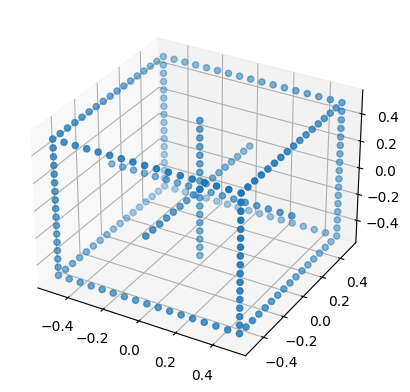

In [5]:
Q = getcube(16)
ax = plt.axes(projection='3d')
ax.scatter3D(Q[:,0],Q[:,1],Q[:,2])

In [6]:
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-2.5) * spatialmath.SE3.Rx(2*DEG2RAD) * spatialmath.SE3.Ry(0*DEG2RAD) * spatialmath.SE3.Rz(3*DEG2RAD),
}
cam = mv.CentralCamera(**params)
cam, cam.K
K = cam.K
# cam rotate the camera like here : )
cam.pose = cam.pose * spatialmath.SE3.Rz(-3*DEG2RAD)
cam

           Name: default perspective camera [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 640 x 640
           pose: t = 0, 0, -2.5; rpy/yxz = 0°, 2°, 0°
   principal pt: [320.000 320.000]
   focal length: [0.008 0.008]

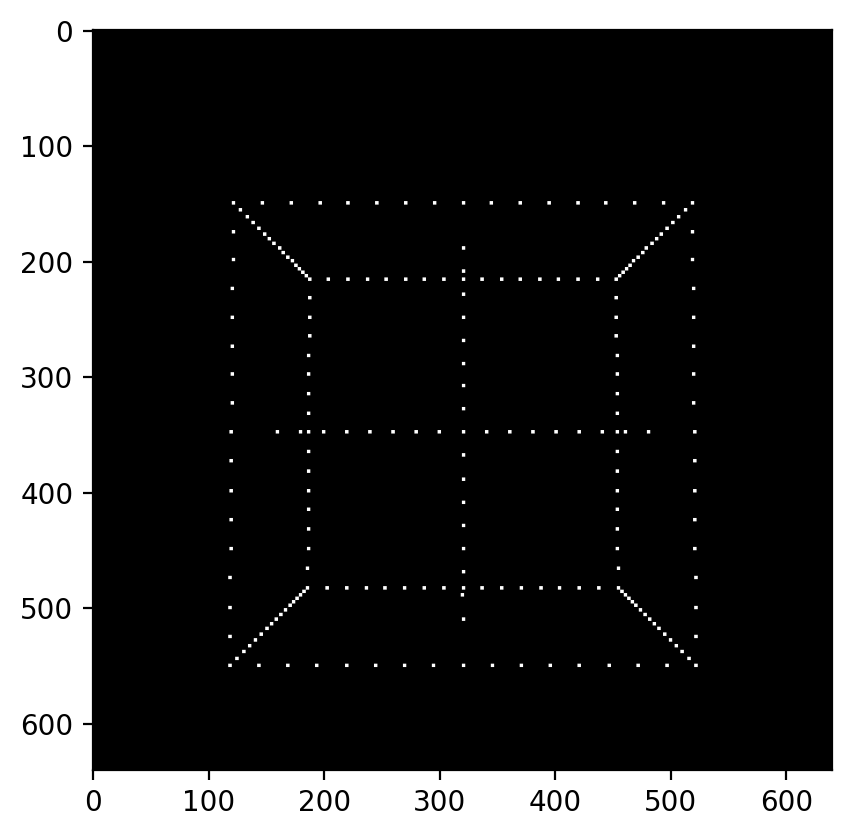

In [7]:
projected, _ = cam.project_point(Q.T[:3, :], visibility=True)
img = np.zeros((640, 640))

for i in range(projected.shape[1]):
    p = projected[:, i]
    if np.isnan(p[0]) or np.isnan(p[1]):
        continue
    u, v = int(p[1]), int(p[0])
    # img[u, v] = 255
    for j in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            if u+j < 0 or u+j >= 640 or v+k < 0 or v+k >= 640:
                continue
            img[u+j, v+k] = 255

plt.figure(dpi=200)
plt.imshow(img, cmap='gray')

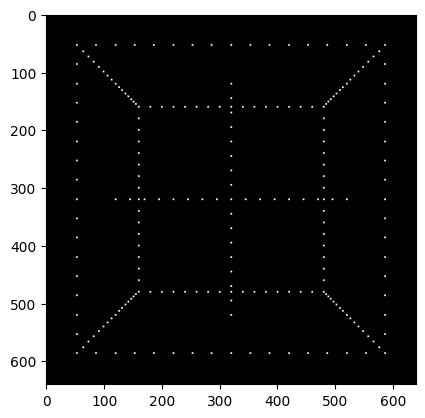

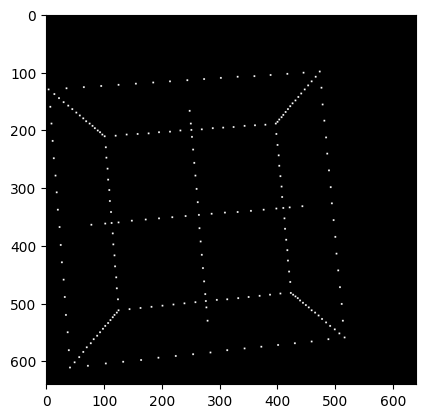

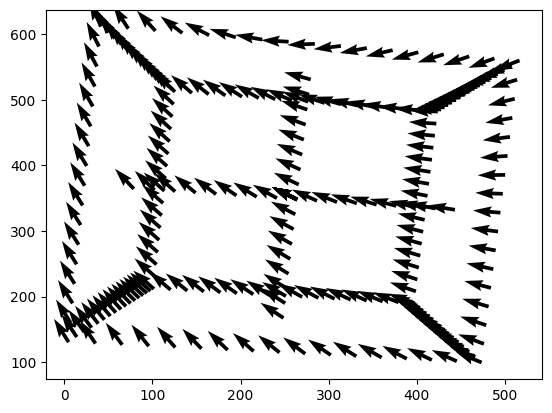

In [8]:
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-2) * spatialmath.SE3.Rx(0*DEG2RAD) * spatialmath.SE3.Ry(0*DEG2RAD) * spatialmath.SE3.Rz(0*DEG2RAD),
}
cam = mv.CentralCamera(**params)

# t = np.array([[0, 0, 2.0]]).T
t = cam.pose.t
N = 2
images = np.zeros((N, 640, 640))
features = np.zeros((N, Q.shape[0], 2))
flow_vectors = np.zeros((N-1, Q.shape[0], 2))
feature_depth = np.zeros((N, Q.shape[0]))

for i in range(images.shape[0]):
    image = images[i]
    projected, _ = cam.project_point(Q.T[:3, :], visibility=True)
    features[i, :, 0] = projected[0, :]
    features[i, :, 1] = projected[1, :]
    feature_depth[i, :] = np.sqrt(
        (Q[:, 0] - t[0])**2 + (Q[:, 1] - t[1])**2 + (Q[:, 2] - t[2])**2)
    if i > 0:
        flow_vectors[i-1, :, 0] = features[i, :, 0] - features[i-1, :, 0]
        flow_vectors[i-1, :, 1] = features[i, :, 1] - features[i-1, :, 1]
    # draw
    for pi in range(projected.shape[1]):
        p = projected[:, pi]
        if np.isnan(p[0]) or np.isnan(p[1]):
            continue
        u, v = int(p[1]), int(p[0])
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                if u+j < 0 or u+j >= 640 or v+k < 0 or v+k >= 640:
                    continue
                image[u+j, v+k] = 255
    # move cam
    if i == 0:
        cam.pose = cam.pose * spatialmath.SE3.Tz(-.2) * spatialmath.SE3.Rz(5*DEG2RAD) * spatialmath.SE3.Ry(
            4*DEG2RAD) * spatialmath.SE3.Rx(2*DEG2RAD)

for im in images:
    plt.figure()
    plt.imshow(im, cmap='gray')
plt.figure()
for i in range(1, Q.shape[0]):
    plt.quiver(features[1, i, 0], features[1, i, 1],
               flow_vectors[0, i, 0], flow_vectors[0, i, 1])

(array([[-0.001],
        [-0.002],
        [-0.189],
        [0.034],
        [0.070],
        [0.078]]),
 array([295.157]),
 0.03490658503988659,
 0.06981317007977318,
 0.08726646259971647)

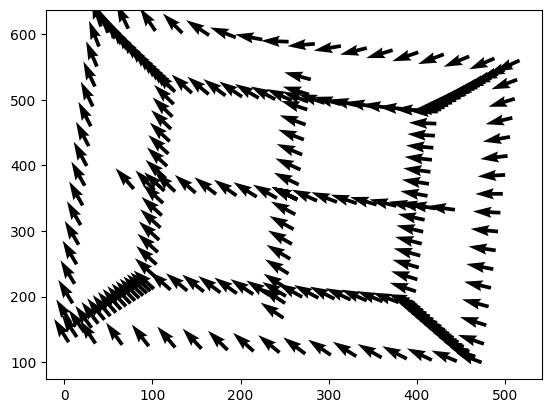

In [9]:
# Robotics Vision And Control 544-543
J = cam.visjac_p(features[0].T, feature_depth[0])

# px_flows = np.matmul(J, [-.05, -.05, -.2, 0,15*DEG2RAD,0])
# cam.pose = cam.pose * spatialmath.SE3.Rz(5*DEG2RAD) * spatialmath.SE3.Ry(4*DEG2RAD) * spatialmath.SE3.Rx(2*DEG2RAD)
px_flows = np.matmul(J, [0, 0, -.2, 2*DEG2RAD, 4*DEG2RAD, 5*DEG2RAD])
px_flows = px_flows.reshape((-1, 2))

plt.figure()
for i in range(1, Q.shape[0]):
    plt.quiver(features[1, i, 0], features[1, i, 1],
               px_flows[i, 0], px_flows[i, 1])

A = J
b = flow_vectors[0].reshape((-1, 1))
x, res, rank, s = np.linalg.lstsq(A, b, rcond=None)
x, res, 2*DEG2RAD, 4*DEG2RAD, 5*DEG2RAD

In [10]:
# replace least squares with ransac
from sklearn import linear_model
ransac = linear_model.RANSACRegressor(
    # max_trials=1000,
    # stop_probability=0.99,
    # min_samples=100,
)
ransac.fit(A, b)
print(ransac.estimator_.coef_[:3], ransac.n_trials_,
      ransac.inlier_mask_.sum(), ransac.score(A, b))

[[-0.001 -0.001 -0.189 0.032 0.072 0.078]] 1 478 0.9997433019215175
